In [30]:
!pip install scipy
!pip install rouge_score
!pip install Levenshtein
!pip install matplotlib
!pip install seaborn

In [31]:

import json
import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
from rouge_score import rouge_scorer
import Levenshtein
import matplotlib.pyplot as plt
import seaborn as sns


In [32]:
#load data for evaluation (loki generated atomic claims)
#specify filename
file_name = "results_FCGPT_phi4_14b-fp16_czprompt.json"
path = "filtered_results/" + file_name
with open(path, 'r') as file:
    generated = json.load(file)
if 'FCGPT' in file_name:
    with open('data/dataset_FCGPT.json', 'r') as file:
        ground_truth = json.load(file)
else:
    with open('data/dataset_comments.json', 'r') as file:
        ground_truth = json.load(file)

print("Length of generated: ", len(generated))
print("Length of ground_truth: ", len(ground_truth))

print(generated[1])
print(ground_truth[1])


Length of generated:  94
Length of ground_truth:  94
{'source': 'Spojené státy mají dva černé prezidenty: Barack Obama, který sloužil dva termíny v letech 2009 až 2017 a Donald Trump, který sloužil jeden termín v letech 2017 až 2021. Obama byl první černý prezident v historii Spojených států. Narodil se v Honolulu na Havaji, aby matka z Kansasu a otec z Keni. Trump byl druhý černý prezident. Narodil se v New Yorku a dříve sloužil jako obchodník a reality televizní osobnost.', 'claims': [{'id': 0, 'claim': 'Spojené státy mají dva černé prezidenty.', 'checkworthy': True, 'checkworthy_reason': 'Výrok tvrdí faktickou informaci o počtu černých prezidentů Spojených států, což je ověřitelné.', 'origin_text': 'Spojené státy mají dva černé prezidenty:', 'start': 0, 'end': 40}, {'id': 1, 'claim': 'Barack Obama sloužil dva termíny jako prezident Spojených států v letech 2009 až 2017.', 'checkworthy': True, 'checkworthy_reason': 'Výrok obsahuje datovatelné faktické informace o mandátním období Bar

In [33]:

gt_comments = []
for entry in ground_truth:
    #if file_name contains FCGPT
    if 'FCGPT' in file_name:
        claims = []
        for item in entry.get('claims', []):
            if isinstance(item, list):
                claims.extend(item)
            elif isinstance(item, dict):
                claims.append(item.get('claim', ''))
            elif isinstance(item, str):
                claims.append(item)
        gt_comments.append(claims)
    else:
        claims = entry.get('claim', [])
        gt_comments.append(claims)


loki_comments = []
for entry in generated:
    claims = []
    for item in entry.get('claims', []):
        if isinstance(item, list):
            claims.extend(item)
        elif isinstance(item, dict):
            claims.append(item.get('claim', ''))
        elif isinstance(item, str):
            claims.append(item)
    loki_comments.append(claims)

print("Length of loki_comments: ", loki_comments[3])
print("Length of gt_comments: ", gt_comments[3])


Length of loki_comments:  ['Kamala Harrisová byla první ženou, která zastávala funkci.']
Length of gt_comments:  ['Už tu byla prezidentka Spojených států.', 'V roce 2021 byla Kamala Harrisová otevřena jako první žena, která zastávala funkci amerického prezidenta.']


In [34]:
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True) #'rouge1', 'rouge2',


def compute_rouge_f1(reference, candidate):
    scores = scorer.score(reference, candidate)
    rougeL_f1 = scores['rougeL'].fmeasure

    return rougeL_f1

In [35]:
all_scores = []
all_pairs = []
comment_metrics = []
threshold = 0.7

for i, (gt_claims_comment, gen_claims_comment) in enumerate(zip(gt_comments, loki_comments)):
    # Skip empty comments
    if not gt_claims_comment or not gen_claims_comment:
        continue

    # Create similarity matrix for this comment
    num_gt = len(gt_claims_comment)
    num_gen = len(gen_claims_comment)


    # Handle unequal number of claims
    max_claims = max(num_gt, num_gen)
    similarity_matrix = np.zeros((max_claims, max_claims))

    # Fill similarity matrix (missing claims get 0 similarity)
    for i in range(min(num_gt, max_claims)):
        for j in range(min(num_gen, max_claims)):
            similarity_matrix[i, j] = compute_rouge_f1(gt_claims_comment[i], gen_claims_comment[j])

    # Apply Hungarian algorithm
    cost_matrix = -similarity_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Get valid matches (ignoring padding)
    matches = [(r, c) for r, c in zip(row_ind, col_ind)]
    valid_matches = [(r, c) for r, c in zip(row_ind, col_ind)
                     if r < num_gt and c < num_gen]

    if not valid_matches:
        continue

    # Calculate metrics for this comment
    comment_scores = [similarity_matrix[r, c] for r, c in valid_matches]
    # Calculate average of all pairs with non empty generated claims
    comment_scores_strict = [similarity_matrix[r, c] for r, c in matches if c < num_gen]
    avg_score = np.mean(comment_scores)
    avg_score_strict = np.mean(comment_scores_strict)

    # Track matched pairs
    # Track all pairs (including those not valid)
    comment_pairs = [
        {
            'Comment_Index': i,
            'GT_Claim': gt_claims_comment[r] if r < num_gt else " ",
            'Generated_Claim': gen_claims_comment[c] if c < num_gen else " ",
            'Score': similarity_matrix[r, c]
        }
        for r, c in zip(row_ind, col_ind)
    ]

    # Calculate comment-level metrics
    good_matches = sum(1 for score in comment_scores if score >= threshold)
    recall = good_matches / num_gt if num_gt > 0 else 0
    precision = good_matches / num_gen if num_gen > 0 else 0
    good_matches_strict = sum(1 for score in comment_scores_strict if score >= threshold)

    #print the pairs which were matched
    #print("Matched pairs for comment {}: ".format(i))
    #for pair in comment_pairs:
    #    print("GT Claim: ", pair['GT_Claim'])
    #    print("Generated Claim: ", pair['Generated_Claim'])
    #    print("Score: ", pair['Score'])
    #print("")

    # Add comment metrics
    comment_metrics.append({
        'Comment_Index': i,
        'Avg_Score': avg_score,
        'Recall': recall,
        'Precision': precision,
        'Avg_Score_Strict': avg_score_strict,
        'GT_Claims': num_gt,
        'Gen_Claims': num_gen,
        'Good_Matches': good_matches,
        'Good_Matches_Strict': good_matches_strict,
    })

    # Add to overall scores and pairs
    all_scores.extend(comment_scores)
    all_pairs.extend(comment_pairs)

In [36]:
# Convert to DataFrame for easier analysis
df_metrics = pd.DataFrame(comment_metrics)

# Overall metrics
overall_avg_score = np.mean(all_scores)
overall_recall = np.mean(df_metrics['Recall'])
overall_precision = np.mean(df_metrics['Precision'])
overall_avg_score_strict = np.mean(df_metrics['Avg_Score_Strict'])
overall_good_matches = np.sum(df_metrics['Good_Matches'])
overall_good_matches_strict = np.sum(df_metrics['Good_Matches_Strict'])

print(f"Overall Average Score: {overall_avg_score:.3f}")
print(f"Overall Recall: {overall_recall:.2%}")
print(f"Overall Precision: {overall_precision:.2%}")

results = [file_name, overall_avg_score, overall_recall, overall_precision, overall_avg_score_strict, overall_good_matches, overall_good_matches_strict]
df_results = pd.DataFrame([results], columns=['File_Name', 'Overall_Avg_Score', 'Overall_Recall', 'Overall_Precision', 'Overall_Avg_Score_Strict', 'Overall_Good_Matches', 'Overall_Good_Matches_Strict'])

file_pairs =  "pairs_" + file_name
# Save the matched pairs to a JSON file
with open(file_pairs, 'w') as f:
    json.dump(all_pairs, f, indent=4)
# Save the metrics to a CSV file
f.close()

file_metrics =  "metrics_" + file_name
# Save the matched pairs to a JSON file
with open(file_metrics, 'w') as f:
    json.dump(comment_metrics, f, indent=4)
# Save the metrics to a CSV file
f.close()



with open('results.csv', 'a') as f:
    df_results.to_csv(f, header=f.tell() == 0, index=False)
f.close()





Overall Average Score: 0.587
Overall Recall: 29.37%
Overall Precision: 38.30%


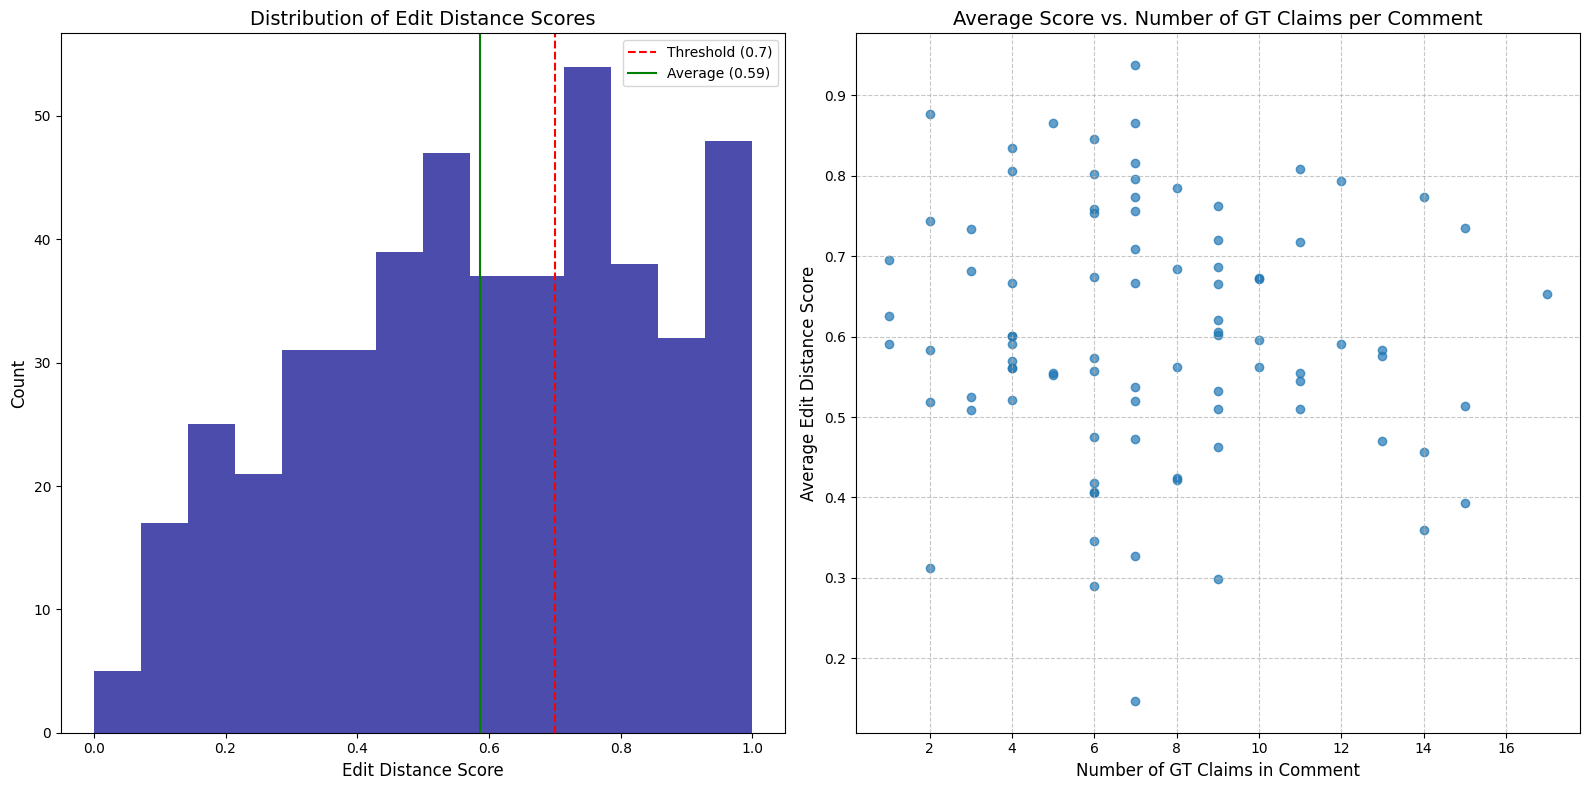

In [37]:
# Visualization
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Distribution of scores
bins = np.linspace(0, 1, 15)
ax1.hist(all_scores, bins=bins, color='darkblue', alpha=0.7)
ax1.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
ax1.axvline(x=overall_avg_score, color='green', linestyle='-', label=f'Average ({overall_avg_score:.2f})')
ax1.set_title('Distribution of Edit Distance Scores', fontsize=14)
ax1.set_xlabel('Edit Distance Score', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.legend()

# Per-comment metrics
ax2.scatter(df_metrics['GT_Claims'], df_metrics['Avg_Score'], alpha=0.7)
ax2.set_title('Average Score vs. Number of GT Claims per Comment', fontsize=14)
ax2.set_xlabel('Number of GT Claims in Comment', fontsize=12)
ax2.set_ylabel('Average Edit Distance Score', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()